<a href="https://colab.research.google.com/github/EddyGiusepe/Neural_Network_from_scratch_only_with_Python/blob/main/GOOD_LEARNING_RATE_Neural_Network_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align="center">Rede Neural usando PyTorch</h2>


Data Scientist.: Dr.Eddy Giusepe Chirinos Isidro

Este script foi baseado no tutorial de [Pepe Cantoral, PhD](https://www.youtube.com/watch?v=qQELiV1_GHA&list=PLWzLQn_hxe6ZlC9-YMt3nN0Eo-ZpOJuXd&index=21).


Neste estudo usaremos `PyTorch` com a ideia de aproveitar o este Framework de Deep Learning. Para começar utilizaremos apenas o `Modulo Sequential`.

# PyTorch

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importamos as nossas bibliotecas

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import random

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F

# Importamos as nossas Imagens

In [3]:
# Importar MNIST
# Ver vídeo para aprender a importar estes Dados: https://www.youtube.com/watch?v=7cMKAlnSmpM

import gzip
import os
from os.path import isfile, join
def list_files(mnist_path):
    return [join(mnist_path,f) for f in os.listdir(mnist_path) if isfile(join(mnist_path, f))]

def get_images(mnist_path):
    for f in list_files(mnist_path):
        if 'train-images' in f:
            with gzip.open(f, 'rb') as data:
                _ = int.from_bytes(data.read(4), 'big')
                num_images = int.from_bytes(data.read(4), 'big')
                rows = int.from_bytes(data.read(4), 'big')
                cols = int.from_bytes(data.read(4), 'big')
                train_images = data.read()
                x_train = np.frombuffer(train_images, dtype=np.uint8)
                x_train = x_train.reshape((num_images, rows, cols))
        elif 'train-labels' in f:
            with gzip.open(f, 'rb') as data:
                train_labels = data.read()[8:]
                y_train = np.frombuffer(train_labels, dtype=np.uint8)
        if 't10k-images' in f:
            with gzip.open(f, 'rb') as data:
                _ = int.from_bytes(data.read(4), 'big')
                num_images = int.from_bytes(data.read(4), 'big')
                rows = int.from_bytes(data.read(4), 'big')
                cols = int.from_bytes(data.read(4), 'big')
                test_images = data.read()
                x_test = np.frombuffer(test_images, dtype=np.uint8)
                x_test = x_test.reshape((num_images, rows, cols))
        elif 't10k-labels' in f:
            with gzip.open(f, 'rb') as data:
                test_labels = data.read()[8:]
                y_test = np.frombuffer(test_labels, dtype=np.uint8)
    
    return x_train, y_train, x_test, y_test    

In [4]:
# Aqui passamos o caminho: MNIST path
# Obviamente os Dados já foram baixados com antecedencia

mnist_path = '/content/drive/MyDrive/2_DEEP_LEARNING_REDES_NEURAIS_Jorge/1_Pytorch_Deep_Learning/Pytorch_examples/Rede_neural_exemplo_Pytorch/data/MNIST/raw/mnist_raw'

In [5]:
# Aqui utilizamos a função "get_images()" 
x_train_num, y_train_num, x_test_num, y_test_num = get_images(mnist_path)


# Aquí dividimos nuestros Datos en train, val y test
# También los convertimos a vectores
x_train = x_train_num[:50000].reshape(50000, -1).astype(np.float32)
y_train = y_train_num[:50000].reshape(50000, 1)

x_val = x_train_num[50000:].reshape(10000, -1).astype(np.float)
y_val = y_train_num[50000:].reshape(10000, 1)

x_test = x_test_num.copy().reshape(10000, -1).astype(np.float)
y_test = y_test_num.copy().reshape(10000, 1)


# Normalizar imagens

In [6]:
# Normalizamos para ter uma média=0 e std=1

def normalise(x_mean, x_std, x_data):
  return (x_data - x_mean) / x_std


In [7]:
x_mean = x_train.mean()
x_std = x_train.std()

print(x_mean, x_std)

33.395157 78.66619


In [8]:
# Aqui teremos nossos Dados Normalizados

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [9]:
# Verificando a média e std para Dados de Treinamento
x_train.mean(), x_train.std()

(-3.1638146e-07, 0.99999934)

In [10]:
# Verificando a média e std para Dados de Validação
x_val.mean(), x_val.std()

(-0.0058509559841872305, 0.9924333474151182)

# Visualizamos algumas das nossas Imagens

In [11]:
x_test.shape

(10000, 784)

In [12]:
y_train.shape

(50000, 1)

In [13]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()
    

A imagem printada representa um: 5


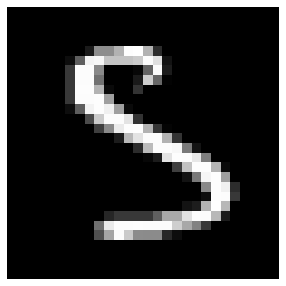

In [14]:
rnd_idx = np.random.randint(len(y_test))
print(f'A imagem printada representa um: {y_test[rnd_idx, 0]}')
plot_number(x_test_num[rnd_idx])

# Criamos a função de Mini-batches

In [15]:
def create_minibatches(x, y, mb_size, shuffle = True):
    '''
    x  # Amostras, 784
    y  # Amostras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Erro em quantidade de amostras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

# Agora sim ... PyTorch

# Converter NumPy array a PyTorch

In [16]:
# Convertendo para Tensores do PyTorch

x_train_tensor = torch.tensor(x_train.copy())
y_train_tensor = torch.tensor(y_train.copy())

x_val_tensor = torch.tensor(x_val.copy())
y_val_tensor = torch.tensor(y_val.copy())

x_test_tensor = torch.tensor(x_test.copy())
y_test_tensor = torch.tensor(y_test.copy())


# Usar GPU de estiver disponível

In [17]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Estammos usando: {device}')

Estammos usando: cuda


# Calculamos Accuracy

In [18]:
def accuracy(model, x, y, mb_size):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in create_minibatches(x, y, mb_size):
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size ) - "dim" é do Pytorch
            num_correct += (pred == yi.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1). squeeze() eliminará esse 1.
            num_total += pred.size(0)

            return float(num_correct)/num_total

# Loop de Treinamento

In [29]:
def train(model, optimiser, mb_size, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for (xi, yi) in create_minibatches(x_train_tensor, y_train_tensor, mb_size):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            # funcion cost
            cost = F.cross_entropy(input= scores, target=yi.squeeze())
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
            
        # Aqui vamos a IMPRIMIR a cada 20 epoch:
        if epoch % 20 == 0:
          
          print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {accuracy(model, x_val_tensor, y_val_tensor, mb_size)}')

# Modelo usando Sequential

In [31]:
#Instanciar modelo
hidden1 = 1000 # Neurônios
hidden = 1000
epochs = 100
mb_size = 4096


# Aqui começamos a PROCURAR um Learning Rate
models = {} # Aqui salvamos os valores do LEARNING RATE
# Buscar no intervalo [0.001, 1]
for i in range(10):
  j = -3*np.random.rand() # [0, 1]
  lr = 10**j 


  # Criamos nosso Modelo
  model1 = nn.Sequential(nn.Linear(in_features=784, out_features=hidden1), # Capa Linear
                       nn.ReLU(), # Capa de função de Ativação
                       nn.Linear(in_features=hidden1, out_features=hidden), # Outra capa Linear
                       nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=10)) # A nossa saída é 10, porque temos 10 classes


  optimiser = torch.optim.SGD(model1.parameters(), lr=lr)

  train(model1, optimiser, mb_size, epochs)
  acc = accuracy(model1, x_val_tensor, y_val_tensor, mb_size)
  print(f'com um lr: {lr} accuracy: {acc}')
  print()
  models[lr] = acc

# Então o processo será treinado 10 vezes  

Epoch: 0, costo: 1.8068968057632446, accuracy: 0.729736328125
Epoch: 20, costo: 0.2715837061405182, accuracy: 0.933349609375
Epoch: 40, costo: 0.2151944637298584, accuracy: 0.94775390625
Epoch: 60, costo: 0.14574167132377625, accuracy: 0.962158203125
Epoch: 80, costo: 0.11774542927742004, accuracy: 0.96875
com um lr: 0.058737801613523495 accuracy: 0.967529296875

Epoch: 0, costo: 2.3119945526123047, accuracy: 0.0732421875
Epoch: 20, costo: 2.113234758377075, accuracy: 0.6083984375
Epoch: 40, costo: 1.9088066816329956, accuracy: 0.7294921875
Epoch: 60, costo: 1.6353808641433716, accuracy: 0.756103515625
Epoch: 80, costo: 1.3552095890045166, accuracy: 0.79150390625
com um lr: 0.0011545848075392505 accuracy: 0.829833984375

Epoch: 0, costo: 1.5533427000045776, accuracy: 0.775634765625
Epoch: 20, costo: 0.1754344254732132, accuracy: 0.940185546875
Epoch: 40, costo: 0.15837019681930542, accuracy: 0.953857421875
Epoch: 60, costo: 0.08913476765155792, accuracy: 0.96435546875
Epoch: 80, costo:

In [34]:
# Visualizamos os valores de lr em ordem decrescente

models_ord = sorted(models.items(), key=lambda x: x[1], reverse = True)

models_ord

[(0.3704656871666868, 0.984130859375),
 (0.11711361932690446, 0.98193359375),
 (0.3005217091537711, 0.980712890625),
 (0.5323659316241888, 0.97998046875),
 (0.11324184971767995, 0.9794921875),
 (0.0807140685478816, 0.975830078125),
 (0.10373958836322973, 0.9755859375),
 (0.058737801613523495, 0.967529296875),
 (0.002685760754266345, 0.88720703125),
 (0.0011545848075392505, 0.829833984375)]

In [38]:
# Sabendo os lr, agora podemos fazer uma busca linear. Já que sabemos mais o menos o valor


#Instanciar modelo
hidden1 = 1000 # Neurônios
hidden = 1000
epochs = 100
mb_size = 4096


# Aqui começamos a PROCURAR um Learning Rate
models = {} # Aqui salvamos os valores do LEARNING RATE
# Buscar no intervalo [0.001, 1]
for i in range(10):
  #j = -3*np.random.rand() # [0, 1]
  #lr = 10**j 
  lr = random.randrange(300, 400)/1000

  # Criamos nosso Modelo
  model1 = nn.Sequential(nn.Linear(in_features=784, out_features=hidden1), # Capa Linear
                       nn.ReLU(), # Capa de função de Ativação
                       nn.Linear(in_features=hidden1, out_features=hidden), # Outra capa Linear
                       nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=10)) # A nossa saída é 10, porque temos 10 classes


  optimiser = torch.optim.SGD(model1.parameters(), lr=lr)

  train(model1, optimiser, mb_size, epochs)
  acc = accuracy(model1, x_val_tensor, y_val_tensor, mb_size)
  print(f'com um lr: {lr} accuracy: {acc}')
  print()
  models[lr] = acc

# Então o processo será treinado 10 vezes  

Epoch: 0, costo: 0.6976284980773926, accuracy: 0.807861328125
Epoch: 20, costo: 0.08700672537088394, accuracy: 0.968994140625
Epoch: 40, costo: 0.01995554193854332, accuracy: 0.9775390625
Epoch: 60, costo: 0.01365243922919035, accuracy: 0.97900390625
Epoch: 80, costo: 0.007882511243224144, accuracy: 0.97998046875
com um lr: 0.365 accuracy: 0.9794921875

Epoch: 0, costo: 0.7646141052246094, accuracy: 0.854248046875
Epoch: 20, costo: 0.0773644745349884, accuracy: 0.968994140625
Epoch: 40, costo: 0.03738639876246452, accuracy: 0.978271484375
Epoch: 60, costo: 0.01837611384689808, accuracy: 0.979248046875
Epoch: 80, costo: 0.012001965194940567, accuracy: 0.980224609375
com um lr: 0.317 accuracy: 0.982177734375

Epoch: 0, costo: 0.6578437089920044, accuracy: 0.729248046875
Epoch: 20, costo: 0.08340995013713837, accuracy: 0.97021484375
Epoch: 40, costo: 0.03490166738629341, accuracy: 0.97607421875
Epoch: 60, costo: 0.01805351860821247, accuracy: 0.981689453125
Epoch: 80, costo: 0.00683540198

In [40]:
# Visualizamos os valores de lr em ordem decrescente, NOVAMENTE

models_ord = sorted(models.items(), key=lambda x: x[1], reverse = True)

models_ord

[(0.357, 0.985107421875),
 (0.349, 0.984130859375),
 (0.333, 0.982421875),
 (0.317, 0.982177734375),
 (0.399, 0.98095703125),
 (0.327, 0.980224609375),
 (0.381, 0.97998046875),
 (0.365, 0.9794921875),
 (0.369, 0.97900390625),
 (0.387, 0.97802734375)]

<font color="orange">Depois de ajustar o Learning Rate procedemos a Treinar nosso modelo com o melhor valor de $lr=0.357$.</font>

In [41]:
#Instanciar modelo
hidden1 = 1000 
hidden = 1000
epochs = 100
mb_size = 4096
# models = {}
# buscar en intervalo [0.001, 1]
# for i in range(5):
#     j = -3*np.random.rand() # [0, 1]
#     lr = 10**j
lr = 0.357
# lr = random.randrange(200, 400)/1000
model1 = nn.Sequential(nn.Linear(in_features=784, out_features=hidden1), nn.ReLU(),
                       nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=10))
optimiser = torch.optim.SGD(model1.parameters(), lr=lr)
train(model1, optimiser, mb_size, epochs)
acc = accuracy(model1, x_val_tensor, y_val_tensor, mb_size)
print(f'con lr: {lr} accuracy:{acc}')
print()
# models[lr] = acc 

Epoch: 0, costo: 0.8130983114242554, accuracy: 0.84765625
Epoch: 20, costo: 0.07844226807355881, accuracy: 0.973876953125
Epoch: 40, costo: 0.028735565021634102, accuracy: 0.97705078125
Epoch: 60, costo: 0.06932836025953293, accuracy: 0.971923828125
Epoch: 80, costo: 0.03191237151622772, accuracy: 0.977294921875
con lr: 0.357 accuracy:0.979248046875



In [42]:
accuracy(model1, x_test_tensor, y_test_tensor, mb_size)

0.977783203125